# R-Learner
R-Learner provides a general framework for estimating causal effects using Machine Learning (ML) algorithms. 

The use of adaptive ML methods for causal inference is appealing because they can handle high-dimensinal data with minimal assumptions on the functional form. However, the inference might be tricky since ML methods trade off variance for bias, and thus might produce biased estimator for the treatment effect. 
Here we will briefly describe the theory behind R-Learner and its implementation in causallib.

We formalize the problem in the potential outcome framework. 

$X_i$ denotes the individual features, $Y_i$ the observed outcome, and $A_i\in \{0, 1\}$ is the treatment assignment. The potential outcome $\{Y_i(0),Y_i(1)\}$, corresponding to the outcome that we would have observed given the treatment $A_i$. We write the conditional response surface as $\mu_{a}(x)=E[Y(a)|X=x]$, for $a\in\{0,1\}$.

We aim to estimate the Average Treatment Effect (ATE), 
$$\tau = E[Y(1)-Y(0)]$$ 
and the Conditional Average Treatment Effect (CATE), 
$$\tau(x)=E[Y(1)-Y(0)|X=x]$$ 

### Semi-parametric setup
Consider the partially linear form: 
$$ Y_i(a)=\mu_{0}(X_i) +a\tau(X_i)+\varepsilon_i $$
where $\varepsilon_i$ is an error term, assuming zero conditional mean $E[\varepsilon_i|X_i,A_i]=0$. 

We can write the conditional mean outcome as follows: 
$$ m(X_i)=E[Y_i|X=x]=\mu_{0}(X_i) +e(X_i)\tau(X_i)$$
where $e(X_i)=Pr[A_i=1|X=x]$ is the propensity model.

Given this setup, we can re-write the function of $\tau(x)$:
$$ Y_i-m(X_i)=[A_i-e(X_i)]\tau(X_i)+\varepsilon_i$$
This decomposition was first introduced by [Robinson](https://www.jstor.org/stable/pdf/1912705.pdf?casa_token=95zyuy2cbqYAAAAA:XFOeNcCphsIkNDismjRHwPCp795ALdHwOACPDkc2f7xkDKwtilZglJmwp-UMuUVarf_J9B50LEkbDwjKvBJfrxfRgBuIQNllQ26X59xichd_9mhslLE) at 1988. [Chernozukov et al.](https://ifs.org.uk/uploads/cemmap/wps/cwp491616.pdf) developed the partially linear (and also the interactive) modelling through the concept of score function and momemt conditions to obtain an estimate of the ATE. Recently, [Nie & Wager](https://arxiv.org/pdf/1712.04912.pdf), utilized this decomposition to create a loss function (named as *R-loss*), that can be optimized in order to estimate the CATE. In addition, they presented error bound for heterogeneous treatment effect via non-parametric kernel regression.

Note that by this construction we are allowing the relation between $X$ and $Y$ and $X$ and $A$ to be non-linear and complex, but still restricting the model estimating the effect to be additive and linear.

### Estimating the effect
Basically, R-Learner is a two-stages procedure:
1. First, estimating the "nuisance models". In this context, nuisance means that we do not directly care about the correctness of our estimate of  $e(X)$ and $m(X)$, as far as we get a good estimate for the causal effects.
    - <i>treatment_model</i> - regressing $A$ on $X$ in order to obtain an esimtate of $\hat{e}(X)$
    - <i>outcome_model</i> - regressing $Y$ on $X$ in order to obtain an esimtate of $\hat{m}(X)$
2. Then, minimize the R-loss:
$$ \tau^*(\cdot) = argmin_{\tau}\left\{ E\left[(Y_i-\hat{m}(X_i)) - (A_i-\hat{e}(X_i))\tau(X_i) \right] \right\}$$

In principle this method is a regression of residuals, which has a long history in the statistics literature.
The residuals simplify the effect estimation since most of the variance is already explained by the nuisance model, thus the effect model is left with a simpler modelling problem.
Note that the covariates used for fitting the effect model in the second stage do not have to be the same set of covariates that is required to remove confounding. For example, they can be smaller set of factors we care for the most when examining how heterogeneous the effect is in these strata

A common technique to avoid bias from overfitting is <b>cross-fitting</b>, where the predicted value of the nuisance models for the $i$-th data point is fitted using a subsample of the data that does not contain the $i$-th data point. For example, we can split the data into two folds. Using one fold for stage (1) and the second fold for stage (2), and then run the same procedure but with switched folds (i.e. fold two for stage (1) and fold one for stage (2)).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_palette("deep")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


from causallib.estimation import StratifiedStandardization, Standardization
from causallib.estimation import RLearner

# Simulation study for estimating the Average Treatment Effect (ATE)
We are examining three kinds of simulations:
1. <b>SI1 </b> - the response surface is relatively simple, but the treatment assigment is highly imbalanced. In addition, the effect is given as a step function, dependent on one covariate. 
2. <b>SI3 </b> - complex nonlinear, balanced groups. The response surface is nonlinear and the effect is heterogeneous, but the treatment assignment is fully-randomized, with probability $0.5$ to be in one of the groups.
3. <b>dml </b> - complex response and treatment mechanism. The true individual effect is homogenous and was set to $\tau=0.5$.

Simulations SI1 & SI3 are based on the paper: [<i>"Supporting Information: Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning"<i>](), and Simulation dml appeared as an introductory example in [<i>"Double machine learning for treatment and causal parameters"<i>](https://ifs.org.uk/uploads/cemmap/wps/cwp491616.pdf). 

As a benchmark we are presenting the results of R-Learner, comparing to S-Learner (Standardization) and T-Learner (Stratified Standardization). 
<b>Note that we are showing results with 100 simulations runs, which might take some time to run on your local computer. </b>

In [4]:
def _generate_X(n, d, seed=0):
    rng = np.random.RandomState(seed)
    sigma = np.array([[0.7**(np.abs(i-j)) for i in range(d)]
                      for j in range(d)])
    X = pd.DataFrame(rng.multivariate_normal(np.zeros(d), sigma, size=n))
    return X
    
def generate_data_SI1(n=500, d=20, seed=0):
    '''
    Simulation SI1 - linear response and imbalanced treatment assignment
    '''
    rng = np.random.RandomState(seed)
    X = _generate_X(n, d, seed)
    a = pd.Series(rng.binomial(1, 0.02, n))
    
    beta = rng.uniform(-5, 5, size=(d,))    
    mu_0 = np.dot(X, beta) + 5 * np.array(X.iloc[:, 0]>0.5)
    mu_1 = mu_0 + 8 * np.array(X.iloc[:, 1]>0.1)
    tau = mu_1 - mu_0
    y = a * mu_1 + (1-a) * mu_0 + rng.normal(size=(n,))
    return {"X": X, "a": a, "y": y, "tau": tau, 'mu_0':mu_0, 'mu_1':mu_1}

def generate_data_SI3(n=500, d=20, seed=0):
    """
    Simulation SI3 - non-linear response and randomized treatment assignment with probability 0.5
    """
    def _univariate_non_linear(x):
        return 2/(1+np.exp(-12*(x-0.5)))
    
    rng = np.random.RandomState(seed)
    X = _generate_X(n, d, seed)
    a = pd.Series(rng.binomial(1, 0.5, n))
    
    x1_nl, x2_nl = _univariate_non_linear(X.iloc[:,0]), _univariate_non_linear(X.iloc[:,1]) 
    mu_0 = -0.5 * np.multiply(x1_nl, x2_nl)
    mu_1 =  0.5 * np.multiply(x1_nl, x2_nl)
    tau = mu_1 - mu_0
    y = a * mu_1 + (1-a) * mu_0 + rng.normal(size=(n,))
    return {"X": X, "a": a, "y": y, "tau": tau, 'mu_0':mu_0, 'mu_1':mu_1}

def generate_data_dml(n=500, d=20, binary_treatment=True, seed=0): 
    """
    Simulation dml - complex response and treatment assignment with homogeneous effect
    """
    from scipy.special import expit
    def m(x):
        return x.iloc[:,0] + 0.25 * expit(x.iloc[:, 2]) 

    def g(x):
        return expit(x.iloc[:,0]) + 0.25 * x.iloc[:, 2]

    rng = np.random.RandomState(seed)
    err = rng.normal(0, 1, 2*n)
    eps, eta = err[:n], err[n:]  
    tau = 0.5
    
    X = _generate_X(n, d, seed)
    M = m(X)
    a = 1*(pd.Series(M + eps) > 0.1) if binary_treatment else pd.Series(M + eps)   
    
    mu_0 = g(X)
    mu_1 = tau + mu_0
    y = pd.Series(np.dot(tau, a) + mu_0 + eta)    
    return {"X": X, "a": a, "y": y, "tau": tau, 'mu_0':mu_0, 'mu_1':mu_1}

def simulation_runner(data_generating_func, n_repetitions=100):
    """
    Generating results of estimated effect for all of the models
    """
    results = list()
    for seed in range(n_repetitions):
        data = data_generating_func(seed)
        for model_name, model in models.items():
            model.fit(data['X'], data['a'], data['y'])
            # estimate Average Treatment Effect
            pop = model.estimate_population_outcome(data['X'], data['a'])
            effect = model.estimate_effect(pop.loc[1], pop.loc[0])['diff']
            results.append((effect, model_name))# , data['tau'].mean()
        results.append((np.mean(data['tau']), 'True_ATE'))
    df_results=pd.DataFrame(results,columns=['effect','method'])#, 'true_effect'])
    return df_results

### Models
We show only a small search of hyperparmeters, but in practice the search can be much more extensive, including also different ML algorithms for the outcome\treatment model.

In [44]:
# nuisance models
treatment_model = LogisticRegression(max_iter=2000)
outcome_model = GridSearchCV(RandomForestRegressor(), 
                             {'max_depth':[2,4,6]}, n_jobs=-1, cv=3)

# causal models
models = {
    'R-Learner': RLearner(outcome_model=outcome_model, 
                          treatment_model=treatment_model, 
                          effect_model=LinearRegression(fit_intercept=False), 
                          effect_covariates=list(), # homogeneous effect
                          n_splits=2, 
                          refit=False),
    'S-Learner': Standardization(outcome_model),
    'T-Learner': StratifiedStandardization(outcome_model),
}

### Simulation SI1
Simple response with imbalanced treatment assignment

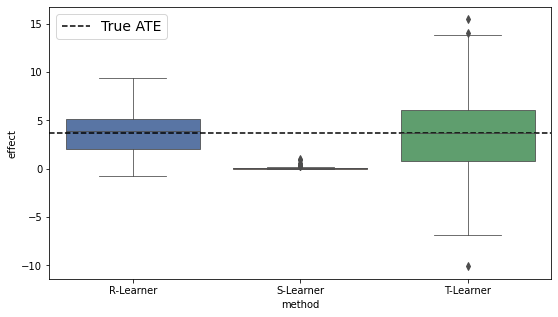

In [62]:
data_generating_func = lambda seed: generate_data_SI1(n=500, d=20, seed=seed)
df_results = simulation_runner(data_generating_func, 100)

# plot the estimated effects
fig, ax = plt.subplots(ncols=1, figsize=(9,5))
sns.boxplot(data=df_results.loc[df_results.method != 'True_ATE',:], 
            y='effect', 
            x='method', 
            linewidth=0.8, 
            ax=ax)
ax.axhline(df_results.loc[df_results.method == 'True_ATE','effect'].mean(), 
           color='black',
           ls='--', 
           label='True ATE')
ax.legend(fontsize=14);

As can be seen, both <b>T-Learner</b> and <b>R-Learner</b> achived an unbiased estimate, but T-Learner has greater variance. Recall that T-Learner estimates each response surface (treated/untreated) separately and without utilizing across-group information, which can reduce statistical power in such highly-imbalanced settings and increase the variance. In addition, <b>S-Learner</b> resulted in highly biased estimate.

### Simulation SI3
Randomized agginment with complex non-linear response and heterogenous effect

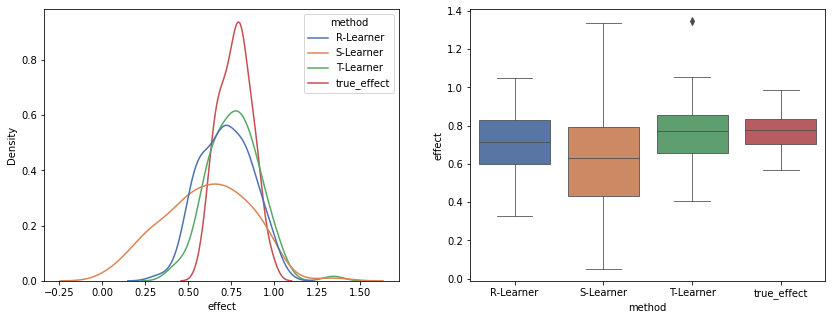

In [69]:
data_generating_func = lambda seed: generate_data_SI3(n=300, d=20, seed=seed)
df_results = simulation_runner(data_generating_func)

# plot the estimated effects
fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.kdeplot(data=df_results, x='effect', hue='method', ax=ax[0])
sns.boxplot(data=df_results, y='effect', x='method', linewidth=0.8, ax=ax[1]);

In this simulation it is best to seperate the effect estimation problem into two problems of estimating the response surface of the treated and the untreated, since there is nothing to learn from the treatment assignment mechnism. <b>T-Learner</b>, which follows this exact strategy performs very well, but only slightly better than <b>R-Learner</b>. Note that these results were achieved even though we restricted the estimated effect of R-Learner to be homogeneous. On the other hand, <b>S-Learner</b> uses a single learner and assumes homogeneity as well, pools all of the data in order to learn that the responses of the groups are in fact quite different. 


# Simulation dml

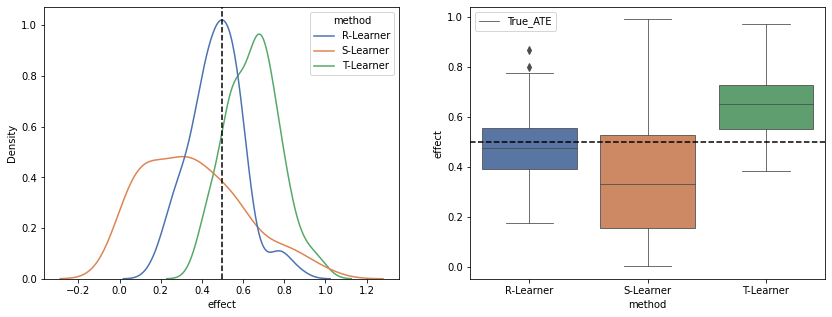

In [105]:
data_generating_func = lambda seed: generate_data_dml(n=400, d=20, seed=seed)
df_results = simulation_runner(data_generating_func)

fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.kdeplot(data=df_results.loc[df_results.method != 'True_ATE',:], 
            x='effect', hue='method', ax=ax[0])
ax[0].axvline(df_results.loc[df_results.method == 'True_ATE','effect'].mean(), 
              color='black',ls='--', label='True_ATE')
sns.boxplot(data=df_results.loc[df_results.method != 'True_ATE',:], 
            y='effect', x='method', linewidth=0.8, ax=ax[1])
ax[1].axhline(df_results.loc[df_results.method == 'True_ATE','effect'].mean(), 
              color='black',ls='--', label='True_ATE')
ax[1].legend(['True_ATE']);

In this simulation, both the response surface and the treatment assignment mechanism are complex and non-linear. Naive implementation of <b>S-Learner</b> or <b>T-Learner</b> leads to biased estimated effect. The <b>R-learner</b>, which is characterized with doubly-robust property permitting the use of slowly converging nuisance models, achieves the lowest effect estimation error. In particular, this property requires that <i>only</i> the product of the approximation errors of the treatment and outcome nuisance models will be $n^{-1/2}$, in order to obtain a root-n estimate to the effect.

# Computing the Conditional Average Treatment Effect (CATE)

We present differences in the models based on the data of simulation SI1. We consider two types of models for R-Learner: 

(1) R-Leraner_hom: assuming homogenous effect, i.e., the model predicts the same individual effect for all units.

(2) R-Learner_het: assuming that the effect is linearly dependent on the covariates (acting as effect-modifiers). 

In [5]:
# set nuisance models
treatment_model = LogisticRegression(max_iter=4000, solver='liblinear',penalty='l1')
outcome_model = LassoCV(max_iter=8000, cv=2)

# causal model
models = {
    'R-Learner_het': RLearner(outcome_model=outcome_model, 
                              treatment_model=treatment_model,
                              effect_model=LassoCV(max_iter=8000, cv=2, fit_intercept=False), 
                              effect_covariates=list(np.arange(1,20)), 
                              n_splits=2, 
                              refit=False),
    'R-Learner_hom': RLearner(outcome_model=outcome_model,
                              treatment_model=treatment_model,
                              effect_model=LinearRegression(fit_intercept=False), 
                              effect_covariates=list(), 
                              n_splits=2, 
                              refit=False),
    'S-Learner': Standardization(outcome_model),
    'T-Learner': StratifiedStandardization(outcome_model),
}

poly = PolynomialFeatures(degree=2, include_bias=False)
results = list()
for n_sample in [400, 700, 1000, 1500, 2000, 3000, 4000]:
    for i in range(50):
        data = generate_data_SI1(n=n_sample, d=20, seed=i)
        data['X'] = pd.DataFrame(poly.fit_transform(data['X']))
        for model_name, model in models.items():
            model.fit(data['X'], data['a'], data['y'])
            ind_outcome = model.estimate_individual_outcome(data['X'], data['a'])
            effect = model.estimate_effect(ind_outcome.loc[:,1], ind_outcome.loc[:,0], 
                                           agg='individual')['diff']
            mse = mean_squared_error(data['tau'], effect)
            results.append((mse, model_name, n_sample))
df_results=pd.DataFrame(results,columns=['mse','method', 'n_sample'])

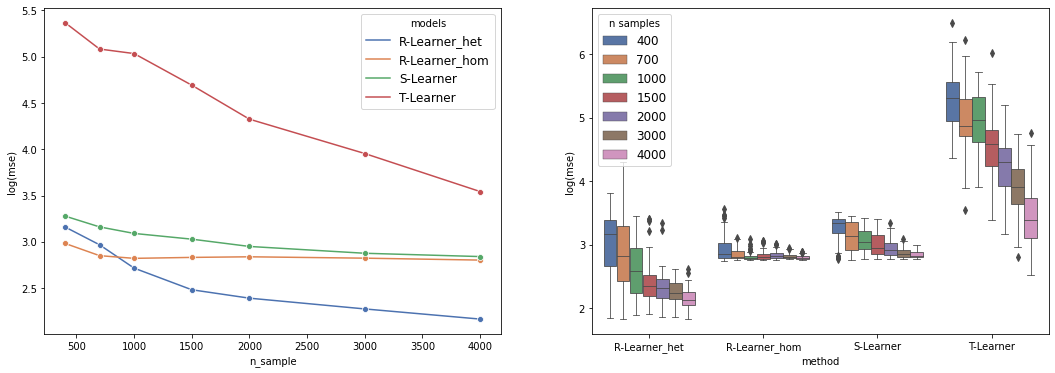

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))

df_results.loc[:,'log(mse)'] = np.log(df_results.loc[:,'mse'])
gdf = df_results.groupby(['method', 'n_sample']).mean().reset_index()
gdf['log(mse)'] = np.log(gdf['mse'])
sns.lineplot(data=gdf, x='n_sample', y='log(mse)', hue='method', marker='o', ax=ax[0])#, alpha=0.8) 
sns.boxplot(data=df_results, y='log(mse)', x='method', hue='n_sample', linewidth=0.8, ax=ax[1])
ax[0].legend(title='models', fontsize=12, loc=1)
ax[1].legend(title='n samples', fontsize=12, loc=2);

We can see that for large sample size, <b>R-Learner_het</b> achieves the lowest effect estimation error. Introduction of heterogeneity increases the number of parameters to be estimated, leading to a large variance in the estimated effect (more apparent when the sample size is small). Therefore, it is important to be careful in choosing an <i>effect_model</i>, and to restrict its complexity in order to control the variance of the estimated effect.

In addition, <b>R-Learner_hom</b> and <b>S-Learner</b> both assume homogeneity, converging to the same effect, but R-Learner_hom does so at a faster rate. <b>T-Learner</b> in this case achieves the poorest results, mainly because of the great variability in estimating the response surface of the treated with small samples.

Below, we present plots of the estimated effect vs. $X_2$. 
Recall that the effect is truly dependent on this variable, $\tau(x)=8 \cdot I_{X_2>0.1}$, where $I$ is an indicator function.

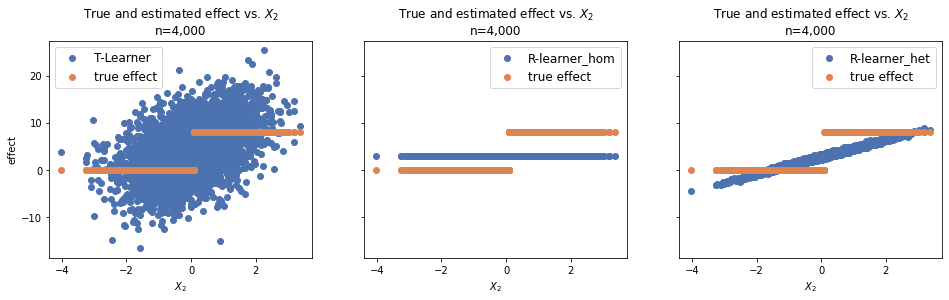

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(16,4),sharey=True)
t_ind_out = models['T-Learner'].estimate_individual_outcome(data['X'], data['a'])
effects = {'T-Learner':  models['T-Learner'].estimate_effect(t_ind_out.loc[:,1], t_ind_out.loc[:,0], agg='individual')['diff'],
           'R-learner_hom': models['R-Learner_hom'].estimate_individual_effect(data['X']),
           'R-learner_het': models['R-Learner_het'].estimate_individual_effect(data['X'])
          }
ax[0].set_ylabel('effect')
for i, model in enumerate(effects):
    ax[i].scatter(data['X'].iloc[:,1], effects[model], label=model)
    ax[i].scatter(data['X'].iloc[:,1], data['tau'], label='true effect')
    ax[i].set_title(f'True and estimated effect vs. $X_2$\nn=4,000')
    ax[i].set_xlabel('$X_2$')
    ax[i].legend(fontsize=12)

A great model for the estimated effect should capture the fact that the true individual effect is equals to $8$ when $X_2$ is greater than 0.1.

As can be seen, <b>T-Learner</b> captured a positive trend, with $X_2$ increasing the estimated effect increasing as well. However, the variance is relatively large. On the other hand, <b>R-Learner_het</b> has captured the same trend in much more compelling way. Since the <i>effect_model</i> in R-Learner_het is a simple LinearRegression, it cannot perfectly estimate the non-linearity of the step-function. <b>R-Learner_hom</b> estimates a constant effect for all units, which is unable to capture any dependence on the features, resulted in an averaged effect.